In [1]:
import os
import numpy as np
import h5py
from datetime import datetime

import gnss_tools.signals.gps_l1ca as GPS_L1CA
from gnss_tools.misc.hdf5_utils import read_hdf5_into_dict

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
user_data_dir = "../data/"

sample_filepath = os.path.join(user_data_dir, "collects/20210611_121000_000100_HI_RX7.sc8")
file_start_time_dt = datetime(2021, 6, 11, 12, 10)

# sample_filepath = os.path.join(user_data_dir, "collects/haleakala_20210611_160000_RX7.dat")
# file_start_time_dt = datetime(2021, 6, 11, 16, 0)

sample_file_id = os.path.basename(sample_filepath)[:-4]

version_id = "0001"
tracking_output_dir = os.path.join(
    user_data_dir, f"asen-6092/tracking-outputs/{sample_file_id}/{version_id}/"
)

filenames = sorted(os.listdir(tracking_output_dir))
outputs = []
for filename in filenames:
    filepath = os.path.join(tracking_output_dir, filename)
    with h5py.File(filepath, 'r') as f:
        outputs.append(read_hdf5_into_dict(f)["tracking"])

In [3]:
print('\n'.join(['{0: >2}: {1}'.format(i, fn) for i, fn in enumerate(filenames)]))

 0: tracking-G02_N-int-01_DLL-BW-05_PLL-BW-20.h5
 1: tracking-G05_N-int-01_DLL-BW-05_PLL-BW-20.h5
 2: tracking-G06_N-int-01_DLL-BW-05_PLL-BW-20.h5
 3: tracking-G09_N-int-01_DLL-BW-05_PLL-BW-20.h5
 4: tracking-G13_N-int-01_DLL-BW-05_PLL-BW-20.h5
 5: tracking-G14_N-int-01_DLL-BW-05_PLL-BW-20.h5
 6: tracking-G17_N-int-01_DLL-BW-05_PLL-BW-20.h5
 7: tracking-G19_N-int-01_DLL-BW-05_PLL-BW-20.h5
 8: tracking-G28_N-int-01_DLL-BW-05_PLL-BW-20.h5
 9: tracking-G31_N-int-01_DLL-BW-05_PLL-BW-20.h5
10: tracking-G32_N-int-01_DLL-BW-05_PLL-BW-20.h5


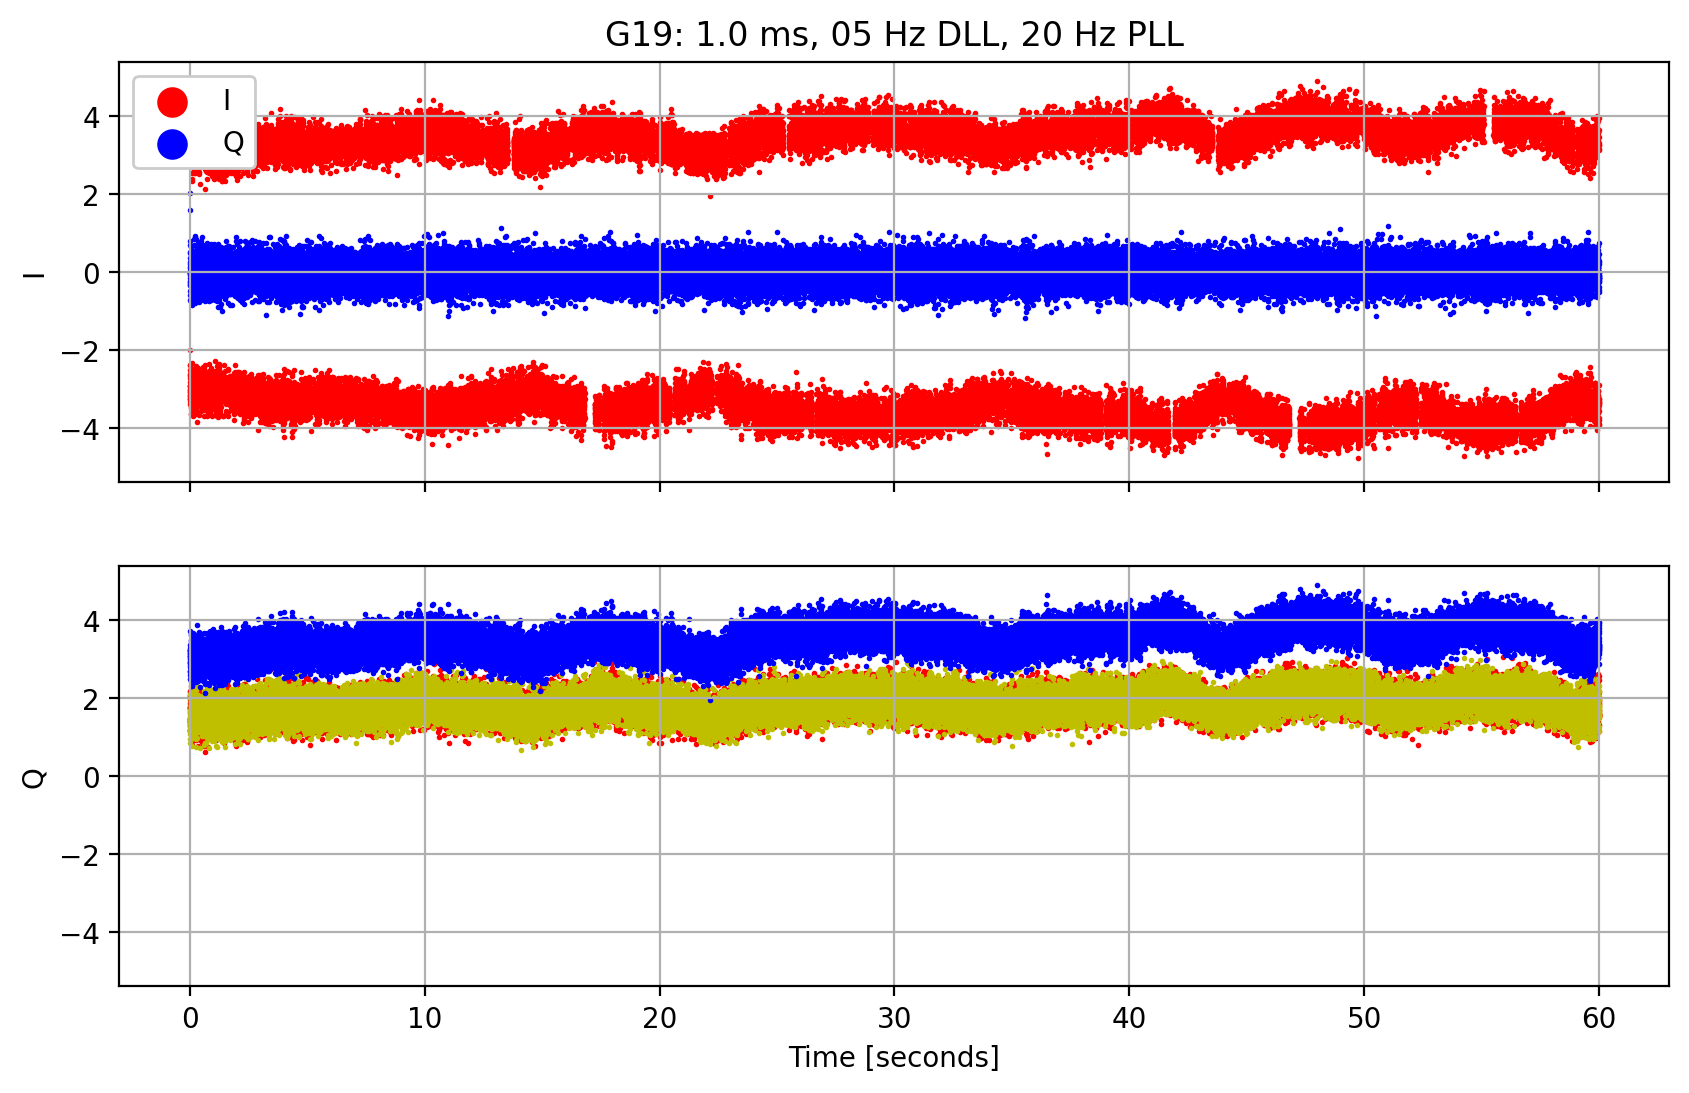

In [4]:
fig = plt.figure(figsize=(10, 6), dpi=200)
axes = [fig.add_subplot(2, 1, 1 + i) for i in range(2)]
ax1, ax2 = axes

i = 7

# ax1.scatter(outputs[i]["time"], np.unwrap(np.angle(outputs[i]["prompt"])), s=1, color="r", label="I")
ax1.scatter(outputs[i]["time"], outputs[i]["prompt"].real, s=1, color="r", label="I")
ax1.scatter(outputs[i]["time"], outputs[i]["prompt"].imag, s=1, color="b", label="Q")

# ax1.scatter(outputs[i]['time'], outputs[i]['prompt'].real, s=1, color='b', label='Prompt')
# ax1.scatter(outputs[i]['time'], outputs[i]['early'].real, s=1, color='y', label='Early')
# ax1.scatter(outputs[i]['time'], outputs[i]['late'].real, s=1, color='r', label='Late')

# ax2.scatter(outputs[i]['time'], outputs[i]['late'].imag, s=1, color='r')
# ax2.scatter(outputs[i]['time'], outputs[i]['early'].imag, s=1, color='y')
# ax2.scatter(outputs[i]['time'], outputs[i]['prompt'].imag, s=1, color='b')

ax2.scatter(outputs[i]["time"], abs(outputs[i]["late"]), s=1, color="r")
ax2.scatter(outputs[i]["time"], abs(outputs[i]["early"]), s=1, color="y")
ax2.scatter(outputs[i]["time"], abs(outputs[i]["prompt"]), s=1, color="b")

ylim = max(np.abs(ax1.get_ylim()))
for ax in axes:
    ax.grid()
    # ax.set_xlim(0, 2)
    ax.set_ylim(-ylim, ylim)
ax1.set_ylabel("I")
ax2.set_ylabel("Q")
ax2.set_xlabel("Time [seconds]")
ax1.set_xticklabels([])
ax1.legend(markerscale=10, loc=2, framealpha=1)
txt_label = "G{0:02}: {1:02} ms, {2:02} Hz DLL, {3:02} Hz PLL".format(
    outputs[i]["prn"],
    1000 * outputs[i]["integration_time"],
    outputs[i]["DLL_bandwidth"],
    outputs[i]["PLL_bandwidth"],
)
ax1.set_title(txt_label)
plt.show()

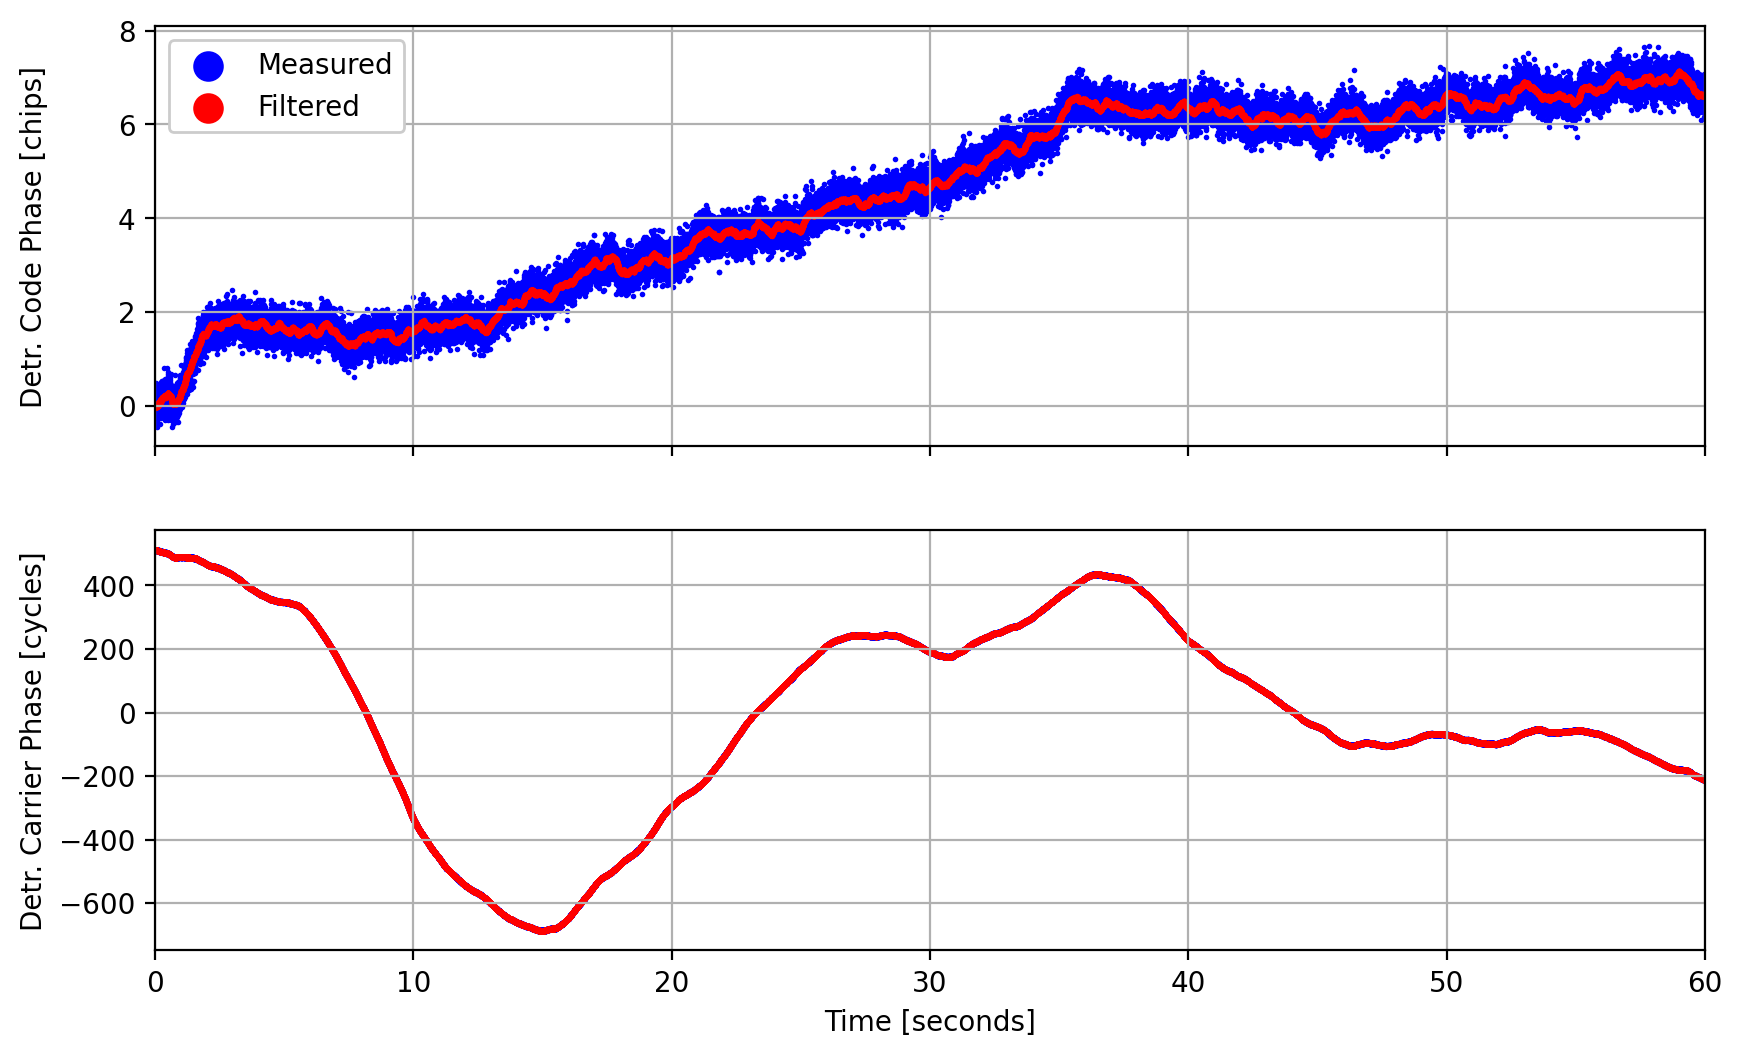

In [5]:
# Compute code and carrier phase trends
i = 1

elapsed_time = outputs[i]['time'] - outputs[i]['time'][0]
ave_doppler = np.mean(outputs[i]['doppler'])

adjusted_code_rate = GPS_L1CA.CODE_RATE * (1 + ave_doppler / GPS_L1CA.CARRIER_FREQ)
code_phase_trend = elapsed_time * adjusted_code_rate

residual_carr_phase = outputs[i]['unfiltered_carr_phase'] - elapsed_time * ave_doppler
carr_phase_trend = elapsed_time * ave_doppler + np.polyval(np.polyfit(elapsed_time, residual_carr_phase, 2), elapsed_time)

# Plot the detrended code and carrier phases
fig = plt.figure(figsize=(10, 6), dpi=200)
axes = [fig.add_subplot(2, 1, 1 + i) for i in range(2)]
ax1, ax2 = axes

ax1.scatter(outputs[i]['time'], outputs[i]['unfiltered_code_phase'] - code_phase_trend, s=1, color='b', label='Measured')
ax1.scatter(outputs[i]['time'], outputs[i]['filtered_code_phase'] - code_phase_trend, s=1, color='r', label='Filtered')
# ax1.scatter(outputs[i]['time'], code_phase_trend, s=1, color='g', label='Filtered')
ax1.set_ylabel('Detr. Code Phase [chips]')


ax2.scatter(outputs[i]['time'], outputs[i]['unfiltered_carr_phase'] - carr_phase_trend, s=1, color='b', label='Measured')
ax2.scatter(outputs[i]['time'], outputs[i]['filtered_carr_phase'] - carr_phase_trend, s=1, color='r', label='Filtered')
ax2.set_ylabel('Detr. Carrier Phase [cycles]')

for ax in axes:
    ax.grid()
    ax.set_xlim(0, 60)
ax1.legend(markerscale=10, loc=2, framealpha=1)
ax1.set_xticklabels([])
ax2.set_xlabel('Time [seconds]')
fig.align_labels()
plt.show()

In [6]:
def compute_cnr(I, Q, bandwidth):
    noise_var = np.var(Q)
    return (I**2 + Q**2) / noise_var * bandwidth

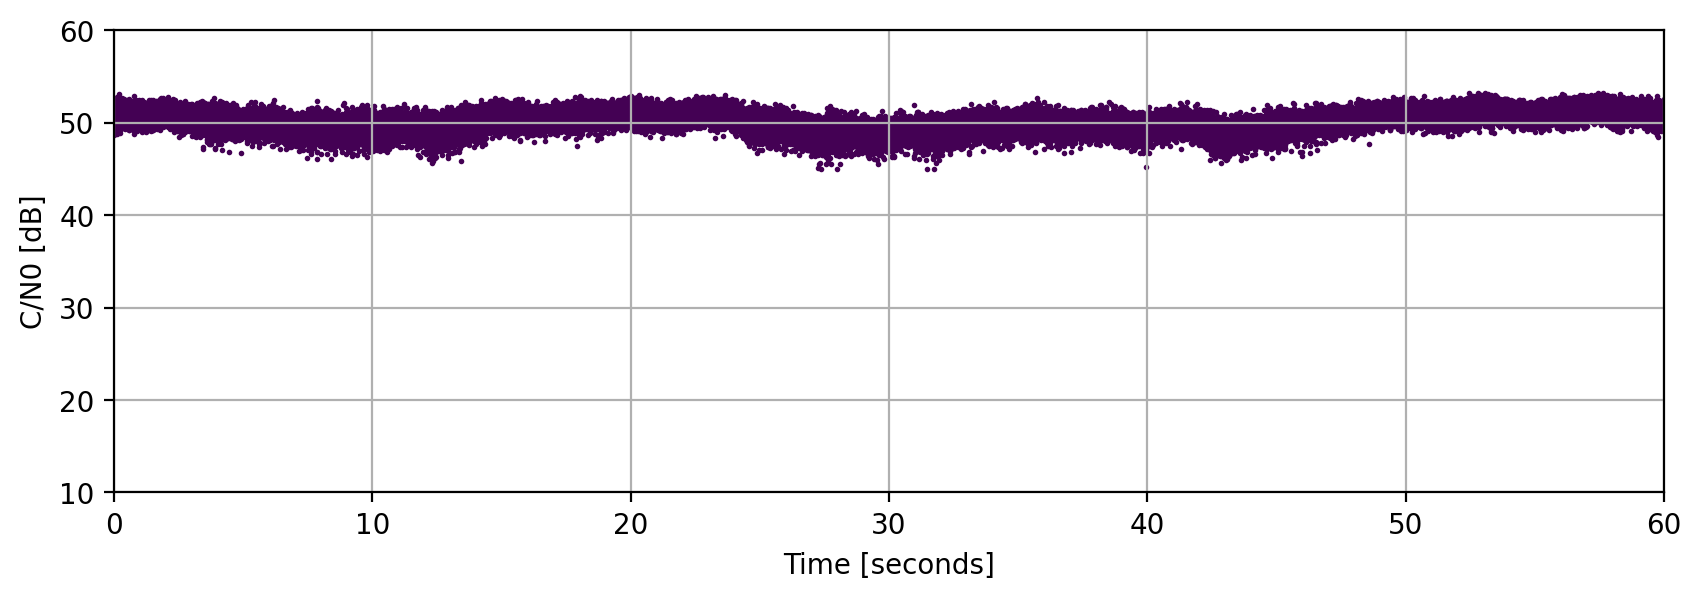

In [7]:
fig = plt.figure(figsize=(10, 3), dpi=200)
ax = fig.add_subplot(111)

indices = [0]
for j, i in enumerate(indices):
    color = plt.cm.viridis(j / len(indices))
    cnr = compute_cnr(outputs[i]['prompt'].real, outputs[i]['prompt'].imag, 1 / outputs[i]['integration_time'])
    ax.scatter(outputs[i]['time'], 10 * np.log10(cnr), s=1, color=color, label='Measured')

ax.set_ylabel('C/N0 [dB]')
ax.set_xlabel('Time [seconds]')
ax.grid()
ax.set_xlim(0, 60)
ax.set_ylim(10, 60)
plt.show()